# One-shot classification of Omniglot characters using a Convolutional Siamese Neural Network

In [3]:
import os
import numpy as np
import random
import matplotlib
from matplotlib import pyplot as plt
import pickle

from PIL import Image

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPooling2D, Activation
from keras.layers import Flatten, Dense, Lambda
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy

%matplotlib inline

# path to the data set
data_path = '/Users/rik/Documents/omniglot/omniglot-master/python/'

# path to directory where intermediates and trained model weights can be saved
save_path = '/Users/rik/Documents/omniglot/saves/'

## Utility functions

Needed for quickly generating filenames and plotting images from the data set

In [4]:
# convert to str and add leading zero to single digit numbers
def num2str(idx):
    if idx < 10:
        return '0'+str(idx)
    return str(idx)


# Generate image filename (full path)
#
# Input
#  alph_dir: directory of alphabet
#  char_id: character index (1 - 20)
#  rend_id: rendition index (1 - 20)
def gen_fn_img(alph_dir, char_id, rend_id):
    img_char_dir = os.path.join(alph_dir,'character'+num2str(char_id))
    fn_rend = os.listdir(img_char_dir)[rend_id-1] # get file name for this rendition
    fn_img = os.path.join(img_char_dir,fn_rend)
    return fn_img


# Load binary image for a character
#
# fn : filename
def load_img(fn):
    I = plt.imread(fn)
    I = np.array(I,dtype=bool)
    return I


# Plot image
def plot_img(I):
    plt.imshow(I, cmap='gray')
    plt.xticks([])
    plt.yticks([])    

## Data inspection

Start with a quick look at the data set, to see what the Omniglot images look like. In particular, get an idea of:
- how the alphabets differ from each other,
- how character within a given alphabets differ, and
- how renditions of a given character differ from one another.

generating figure 1 of 5
generating figure 2 of 5
generating figure 3 of 5
generating figure 4 of 5
generating figure 5 of 5


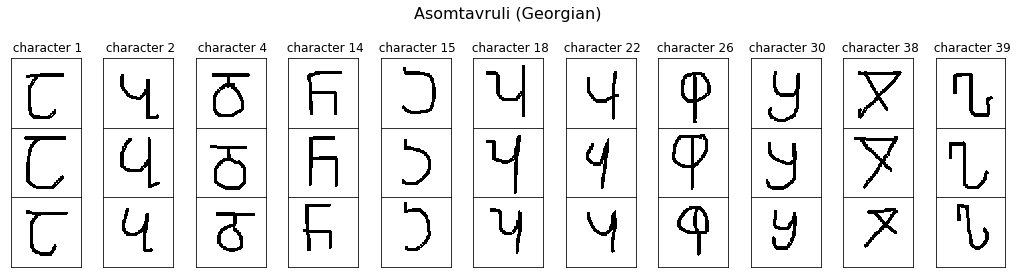

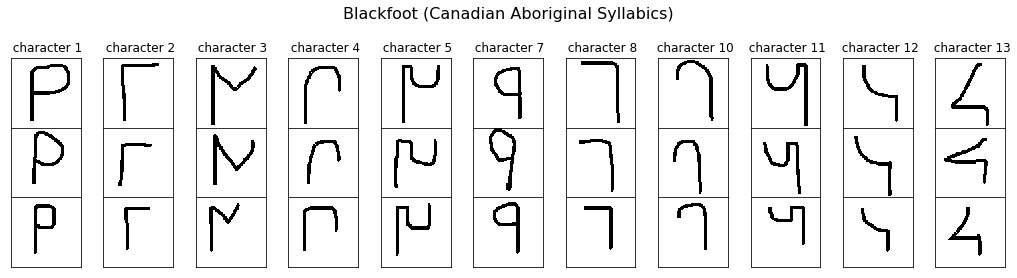

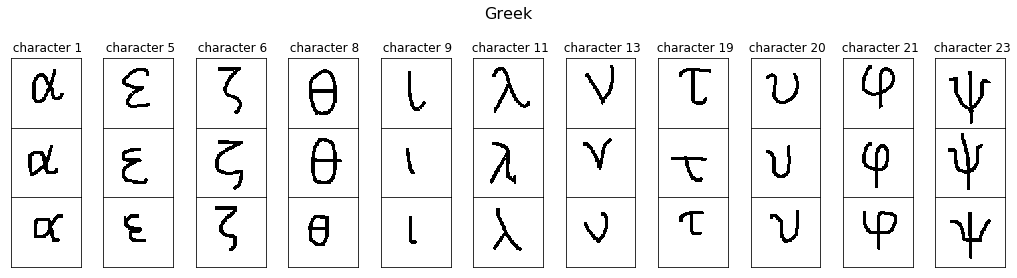

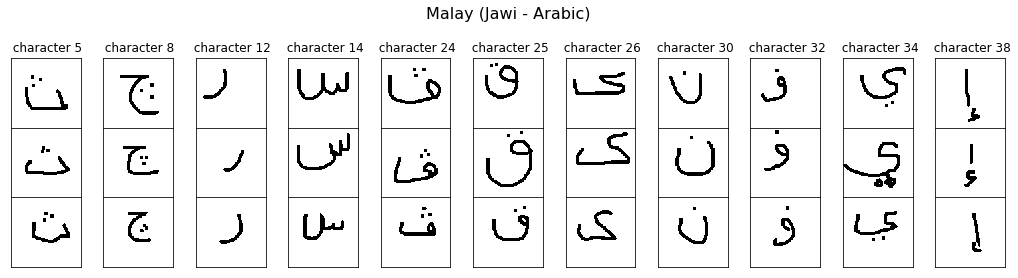

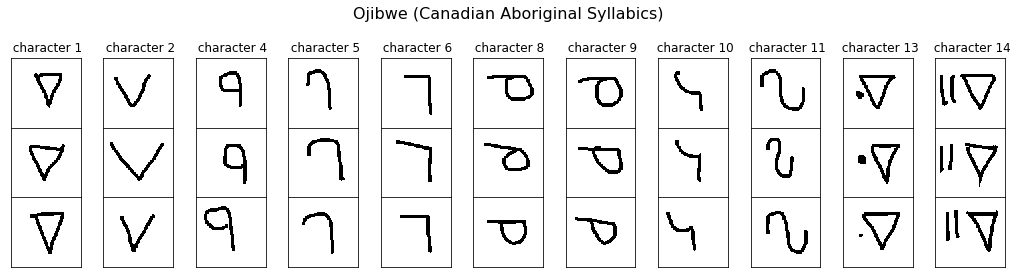

In [5]:
random.seed(1) # seed random number generator, for reproducability

img_dir = data_path + 'images_background'
nalpha = 5 # number of alphabets to show
nchars = 11 # number of characters from each alphabet to show
nreps = 3 # number of renditions for each character

fig_scaling = 1.3

alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names
alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets
alphabet_names.sort()

for a in range(nalpha): # for each alphabet
    print('generating figure ' + str(a+1) + ' of ' + str(nalpha))
    alpha_name = alphabet_names[a]
    alph_dir = os.path.join(img_dir,alpha_name)
    alph_len = len(os.listdir(alph_dir)) # number of characters in current alphabet
    
    plt.figure(a,figsize=(nchars*fig_scaling,nreps*fig_scaling))
    plt.clf()
    plt.suptitle(alpha_name.replace('_',' '), fontsize=16)
    
    char_ids = random.sample(range(1,alph_len+1),nchars) # choose random characters from current alphabet
    char_ids.sort()
    
    for c in range(nchars):

        character_id = char_ids[c]

        for r in range(1,nreps+1): # for each rendition
            plt.subplot(nreps, nchars, c+(r-1)*nchars+1)
            fn_img = gen_fn_img(alph_dir, character_id, r)
            I = load_img(fn_img)
            plot_img(I)
            if r==1:
                plt.title('\n\n character ' + str(character_id))
        plt.tight_layout()
    plt.subplots_adjust(hspace=0)
plt.show()
        

## Image properties

A more detailed inspection of individual Omniglot images shows that brush strokes typically have a width of 5 pixels. The smallest "dots" in the data set (like those seen in some renditions of Braille characters and Latin-alphabet i's and j's) appear as 5x5 clusters of inked pixels.

For this reason, the images can safely be downsampled by a factor 3 to 4. This would facilitate computations by drastically reducing the size of the input arrays, while preserving the character shapes on which the classification depends.

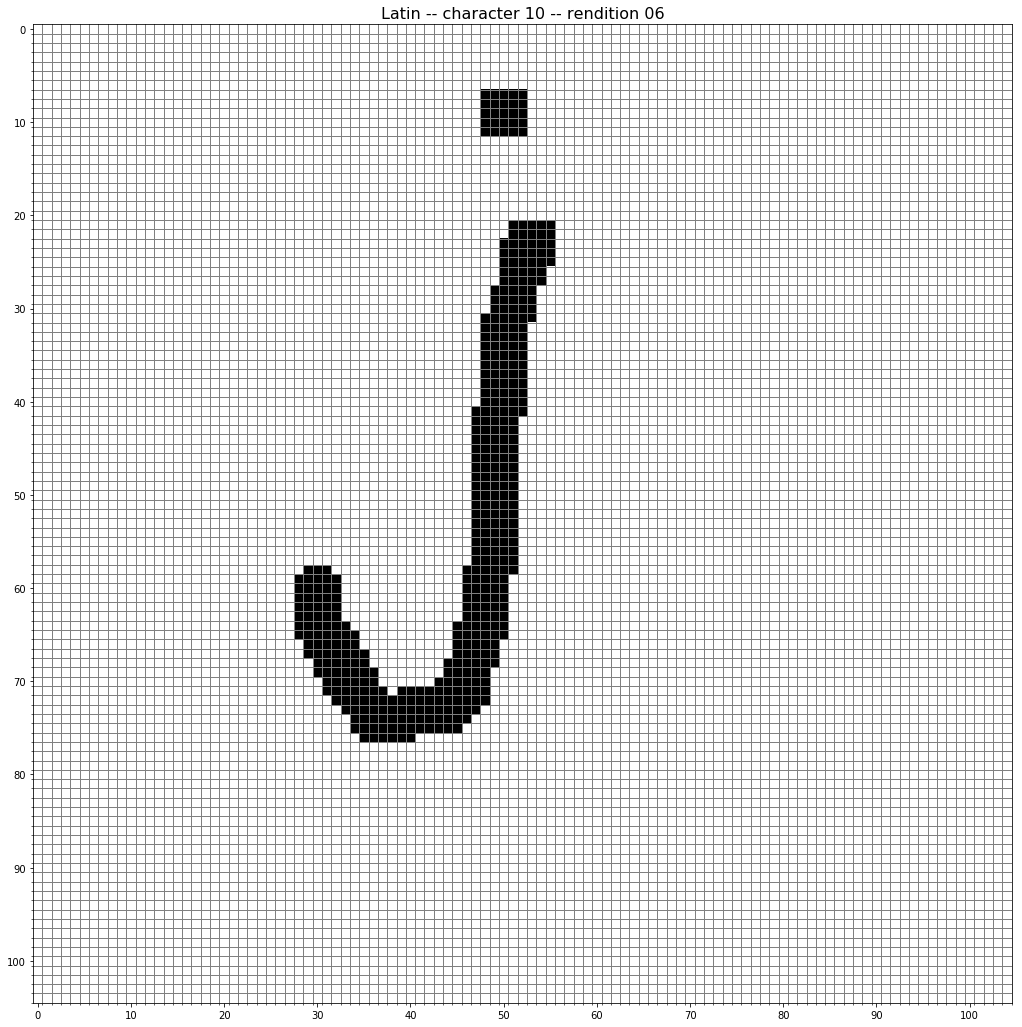

In [6]:
img_dir = data_path + 'images_background'

alpha_name = 'Latin'
# alpha_name = 'Braille'
char_id = 10
rend_id = 5

plt.figure( figsize=(18,18) )
plt.clf()

alph_dir = os.path.join(img_dir,alpha_name)
fn_img = gen_fn_img(alph_dir, char_id, rend_id)
I = load_img(fn_img)
plot_img(I)

ax = plt.gca()

# set major ticks
ax.set_xticks(np.arange(0, 105, 10))
ax.set_yticks(np.arange(0, 105, 10))

# set gridlines based on minor ticks
ax.set_xticks(np.arange(.5, 105, 1), minor=True)
ax.set_yticks(np.arange(.5, 105, 1), minor=True)
ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)

plt.title( alpha_name.replace('_',' ') + ' -- character ' + num2str(char_id) \
          + ' -- rendition ' + num2str(rend_id+1), fontsize=16)

plt.show()

## Classification test for humans

Interactive code to test the character classification skills of a human

Identify which character is shown on the left.
Question 1 out of 5:


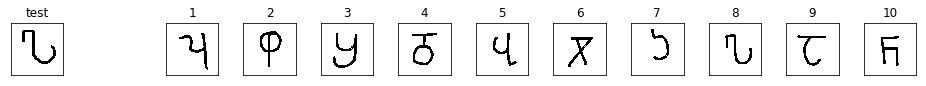

Answer: 8

Correct
These characters were from the Asomtavruli (Georgian) alphabet


Question 2 out of 5:


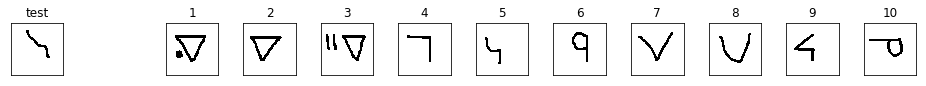

Answer: 5

Correct
These characters were from the Ojibwe (Canadian Aboriginal Syllabics) alphabet


Question 3 out of 5:


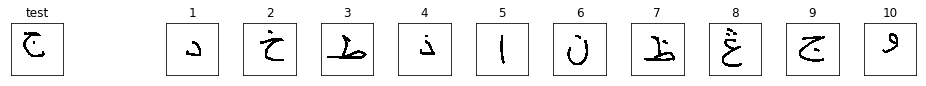

Answer: 9

Correct
These characters were from the Malay (Jawi - Arabic) alphabet


Question 4 out of 5:


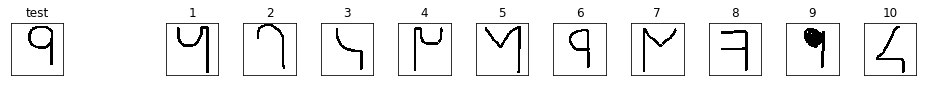

Answer: 6

Correct
These characters were from the Blackfoot (Canadian Aboriginal Syllabics) alphabet


Question 5 out of 5:


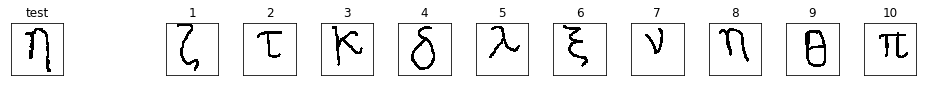

Answer: 8

Correct
These characters were from the Greek alphabet


Result: 100%


In [9]:
random.seed(1) # seed random number generator, for reproducability

img_dir = data_path + 'images_background'
ndrawer = 20 # number of renditions per character in the Omniglot dataset

nquestion = 5 # number of classification questions (i.e., length of the test)
nclass = 10 # number of classes shown; i.e., the n in 'n-way'
nexample = 1 # number of examples per class shown; i.e., the k in 'k-shot'

fig_scaling = 1.3

alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names
alphabet_names = [a for a in alphabet_names if len(os.listdir(os.path.join(img_dir,a))) >= nclass]
alphabet_names = random.sample(alphabet_names,nquestion) # choose random alphabets

cumu_result = 0

print('Identify which character is shown on the left.')

for a in range(nquestion):
    print('Question ' + str(a+1) + ' out of ' + str(nquestion) + ':')
    alpha_name = alphabet_names[a]
    alph_dir = os.path.join(img_dir,alpha_name)
    alph_len = len(os.listdir(alph_dir)) # number of characters in current alphabet
    
    plt.figure(a,figsize=((nclass+1)*fig_scaling,nexample*fig_scaling))
    plt.clf()
    
    # choose n random characters from current alphabet
    char_ids = random.sample(range(1,alph_len+1),nclass)
    
    # pick one character that will be the test character to be classified
    test_char_id = random.choice(char_ids)
    
    # choose k random renditions of character, plus one to serve as test item
    rend_ids = random.sample(range(1,ndrawer+1),nexample+1)
    test_rend_id = rend_ids[0]
    train_rend_ids = rend_ids[1:]
    

    # show test item
    plt.subplot(nexample, nclass+2, 1)
    fn_img = gen_fn_img(alph_dir, test_char_id, test_rend_id)
    I = load_img(fn_img)
    plot_img(I)
    plt.title('test')
    
    for c in range(nclass):

        character_id = char_ids[c]

        for i in range(nexample): # for each rendition
            
            # show training items
            plt.subplot(nexample, nclass+2, c+i*(nclass+2)+3)
            fn_img = gen_fn_img(alph_dir, character_id, train_rend_ids[i])
            I = load_img(fn_img)
            plot_img(I)
            if i==0:
                plt.title(str(c+1))
        plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5, hspace=-0.52)  
    plt.show()
    
    answer = input('Answer: ')
    answer = int(answer)
    result = ( test_char_id == char_ids[answer-1] )
    cumu_result += int(result)
    print('')
    if result:
        print('Correct')
    else:
        print('False... The correct answer was ' + str(char_ids.index(test_char_id)+1))
    print('These characters were from the ' + alpha_name.replace('_',' ') + ' alphabet')
    print('\n')
    
print('Result: ' + str( 100 * cumu_result / nquestion ) + '%')

## Data handling

Create a data structure so that the individual images are easily accessible

Quick check to see if images would fit in RAM (rough lower-limit / order-of-magnitude estimate):  
`characters in Omniglot * images/character * pixels/image * bytes/pixel / (bytes/MB) =`  
`1623                   * 20               * 32*32        * 1           / 1024^2     = 31.7 MB`


In [10]:
# Define data structure

ndrawer = 20 # number of renditions per character in the Omniglot dataset

img_size = 32 # desired image width and height after resampling (from 105, i.e., downsampling factor of about 3.3)


class Rendition(object):
    
    def __init__(self, char_dir, rend_id):
        
        # filename of this rendition
        rend_fn = os.listdir(char_dir)[rend_id]
        rend_fn = os.path.join(char_dir,rend_fn)
        
        # load image, resize, convert to numpy boolean array, take negative
        img = Image.open(rend_fn)
        img = img.resize((img_size, img_size), resample=Image.LANCZOS)
        img = np.asarray(img)
        self.img = np.logical_not(img)


class Character(object):
    
    def __init__(self, alph_dir, char_id):
        
        char_dir = os.path.join(alph_dir, 'character' + num2str(char_id))
        
        first_filename = os.listdir(char_dir)[0]
        self.char_name = first_filename[:first_filename.find('_')]
        
        # generate list of renditions of this character
        self.rends = []
        for rend_id in range(ndrawer):
            self.rends.append( Rendition(char_dir, rend_id) )


class Alphabet(object):
    
    def __init__(self, img_dir, alpha_name):
        
        # name of alphabet (string)
        self.name = alpha_name
        
        # path to alphabet
        alph_dir = os.path.join(img_dir, alpha_name)
        
        # number of characters in this alphabet
        self.len = len( os.listdir( alph_dir ) )
        
        # generate list of characters in this alphabet
        self.chars = []
        for char_id in range( 1, self.len + 1 ):
            self.chars.append( Character(alph_dir, char_id) )
       

In [11]:
# Load images into memory, with resizing
# 
# Input
#  img_dir: path to directory containing alphabet folders
# 
# Output
#  alph_list: list of Alphabet objects
def load_data(img_dir):
    
    print( 'Looking for alphabets in directory:\n ' + img_dir + '\n' )
    
    # get folder names
    alphabet_names = [ a for a in os.listdir( img_dir ) if a[0] != '.' ]
    
    # number of alphabets
    nalpha = len( alphabet_names )

    # generate list of Alphabet objects
    alph_list = []
    for a in range(nalpha):
        alpha_name = alphabet_names[a]
        print( 'Loading alphabet %02d out of %02d: %s' % ( a+1, nalpha, alpha_name.replace('_',' ') ) )

        alph_list.append( Alphabet( img_dir, alpha_name ) )
        
    return alph_list

In [19]:
# Create data subsets

# paths to directories with alphabets
img_dir_bg = data_path + 'images_background'
img_dir_ev = data_path + 'images_evaluation'

# generate lists of Alphabet objects
alphs_bg = load_data( img_dir_bg )
alphs_ev = load_data( img_dir_ev )

# save pickled data subsets
with open( os.path.join( save_path, 'img_bg.pkl' ), 'wb' ) as f:
    pickle.dump(alphs_bg,f)
with open( os.path.join( save_path, 'img_ev.pkl' ), 'wb' ) as f:
    pickle.dump(alphs_ev,f)

Looking for alphabets in directory:
 /Users/rik/Documents/omniglot/omniglot-master/python/images_evaluation
Loading alphabet 01 out of 20: Angelic
Loading alphabet 02 out of 20: Atemayar Qelisayer
Loading alphabet 03 out of 20: Atlantean
Loading alphabet 04 out of 20: Aurek-Besh
Loading alphabet 05 out of 20: Avesta
Loading alphabet 06 out of 20: Ge ez
Loading alphabet 07 out of 20: Glagolitic
Loading alphabet 08 out of 20: Gurmukhi
Loading alphabet 09 out of 20: Kannada
Loading alphabet 10 out of 20: Keble
Loading alphabet 11 out of 20: Malayalam
Loading alphabet 12 out of 20: Manipuri
Loading alphabet 13 out of 20: Mongolian
Loading alphabet 14 out of 20: Old Church Slavonic (Cyrillic)
Loading alphabet 15 out of 20: Oriya
Loading alphabet 16 out of 20: Sylheti
Loading alphabet 17 out of 20: Syriac (Serto)
Loading alphabet 18 out of 20: Tengwar
Loading alphabet 19 out of 20: Tibetan
Loading alphabet 20 out of 20: ULOG


In [12]:
# Load data subsets that were previously saved

with open( os.path.join( save_path, 'img_bg.pkl' ), 'rb' ) as f:
    alphs_bg = pickle.load(f)
with open( os.path.join( save_path, 'img_ev.pkl' ), 'rb' ) as f:
    alphs_ev = pickle.load(f)

## Create model

The method used here is a Convolutional Siamese Neural Network, an intuitive and powerful meta-learning tool used for one-shot classification tasks. This network consists of two identical "legs" that extract features from two input images. The output of these legs are then combined by computing a distance metric between them. 

The specific network architecture used for each of the Siamese legs is based on the one used for Omniglot classification by
_Vinyals et al. (2016: Matching networks for one shot learning. Neural Information Processing Systems)._
This network uses a series of convolutional blocks consisting of

- 3 × 3 convolutions and 64 filters,
- batch normalization,
- a ReLU nonlinearity, and
- 2 × 2 max-pooling.

A series of 5 such blocks converts the 32 x 32 input image of each leg into a 1 x 1 x 64 feature map, which is then passed through a fully connected layer of 64 neurons with sigmoid activation, yielding the output feature vector of the Siamese leg.

Following
_Koch et al. (2015: Siamese neural networks for one-shot image recognition. ICML Deep Learning Workshop),_
the output feuture vectors of the two Siamese legs are combined by a layer that computes the component-wise L1 distance between them. The resulting vector of distances is passed through a fully connected layer with a single output unit with sigmoid activation. The final output (a single number between 0 and 1) should be treated as the probability of the two input images belonging to the same class.


In [13]:
# Create keras model

# shape of down-sampled Omniglot image: img_size x img_size, 1-channel booleans
img_size = 32
input_shape = (img_size, img_size, 1)

# number of convolutional filters, this is the number of "neurons" in each layer
n_filters = 64

# convolution filter size, i.e. we will use a n_conv x n_conv filter
n_conv = 3

# pooling window size, i.e. we will use a n_pool x n_pool pooling window
n_pool = 2

# number of convolutional blocks (each consisting of Conv, BN, ReLU, MaxPool)
# determined by getting img_size down to 1 by sequential maxpooling
n_blocks = 5

# learning rate, to be fine-tuned
# learning_rate = 0.0001
# learning_rate = 0.00001
# learning_rate = 0.001
learning_rate = 0.01


# --- Siamese leg ---

# instantiate ConvNet to use in each of the two Siamese 'legs'
siamleg = Sequential()

# # inert layer passing the input
# siamleg.add( Reshape(input_shape=input_shape, target_shape=input_shape) )
    
# add n_modules modules
# (input_shape only used for first layer, subsequently ignored)
for _ in range(n_blocks):
    siamleg.add( Conv2D(n_filters, (n_conv, n_conv), padding='same', input_shape=input_shape) )
    siamleg.add( BatchNormalization() )
    siamleg.add( Activation('relu') )
    siamleg.add( MaxPooling2D( pool_size=(n_pool, n_pool) ) )

# flatten into vector
siamleg.add( Flatten() )

# fully connected layer yielding the final feature vector of the Siamese leg
siamleg.add( Dense(n_filters) )
siamleg.add( Activation('sigmoid') )

# show summary of single Simaese leg
print(siamleg.summary())


# --- Combine Siamese legs ---

# instantiate inputs
input_leg1 = Input( shape=input_shape )
input_leg2 = Input( shape=input_shape )

# encode both Siamese legs
output_leg1 = siamleg( input_leg1 )
output_leg2 = siamleg( input_leg2 )

# measure component-wise distance between feature vectors produced by Siamese legs
distances = Lambda( lambda vectors : K.abs( vectors[0] - vectors[1] ) )( [output_leg1, output_leg2] )

# fully connected layer producing a measure of similarity from an input vector of distances
# output lies between 0 and 1, with 1 representing identical inputs
output = Dense( 1, activation='sigmoid' )( distances )

# implement model
siammodel = Model( [ input_leg1, input_leg2 ], output )

print(siammodel.summary())

# compile model
siammodel.compile( loss=binary_crossentropy , optimizer=Adam( lr=learning_rate ) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
__________

## Training and validation functions

Train on batches of same-or-different tasks.  
Validate using 20-way one-shot tasks.  
To remain consistent with the original Omniglot challenge task, pick characters from within the same alphabet for each task.

In [14]:
# Generate batch of image pairs (each pair is drawn from a single alphabet)
# half of these pairs are of the same character (but different renditions)
# the other half are of different characters (and still different renditions)
# 
# Input
#  alph_list: list of Alphabet objects to use
#  batch_size: number of image pairs to generate
# 
# Output
#  pairs: list of two lists (length: batch_size) of images
#  targets: list of integers indicating whether image pair is of same class (1) or not (0)
def gen_batch( alph_list, batch_size ):
    
    # select random alphabets with replacement
    alphs = [ random.choice(alph_list) for _ in range(batch_size) ]
    
    # matching labels for first half, non-matching for second half
    targets = np.zeros( batch_size, dtype=int )
    targets[:batch_size//2] = 1
    
    # initialise
    items1 = np.zeros( ( batch_size, img_size, img_size, 1 ) )
    items2 = np.zeros( ( batch_size, img_size, img_size, 1 ) )
    
    for i in range(batch_size):
        
        # pick two random characters for the two images (without replacement)
        char_ids = random.sample( range(alphs[i].len), 2 )
        
        # for the pairs that should match, make them matching
        if targets[i] == 1:
            char_ids[1] = char_ids[0]
        
        # pick random randitions for the two images (without replacement)
        rend_ids = random.sample( range(ndrawer), 2 )

        # collect items, and place them in tensors
        items1[i,:,:,0] = alphs[ i ].chars[ char_ids[0] ].rends[ rend_ids[0] ].img
        items2[i,:,:,0] = alphs[ i ].chars[ char_ids[1] ].rends[ rend_ids[1] ].img
    
    
    pairs = [ items1, items2 ]
    
    return pairs, targets



# Perform a single n-way, one-shot classification test
# 
# Input
#  model: keras model of Siamese CNN comparing pair of items
#  alph: Alphabet object from which images will be drawn
#  nway: number of classes shown in test; i.e., the n in 'n-way classification'
# 
# Output
#  correct: boolean whether test was answered correct
def oneshot_test( model, alph, nway ):
    
    # choose n random characters from alphabet
    char_ids = random.sample( range(alph.len), nway )
    
    # pick one to be character of the test item
    char_id_test = random.choice(char_ids)
    
    # choose two random drawers, one for test item, one for support set
    rend_ids = random.sample( range(ndrawer), 2 )
    rend_id_test = rend_ids[0]
    rend_id_supp = rend_ids[1]

    # collect test and support items, and place them in tensors
    test_items = np.zeros( ( nway, img_size, img_size, 1 ) )
    supp_items = np.zeros( ( nway, img_size, img_size, 1 ) )
    for i in range(nway):
        test_items[i,:,:,0] = alph.chars[ char_id_test ].rends[ rend_id_test ].img
        supp_items[i,:,:,0] = alph.chars[ char_ids[i] ].rends[ rend_id_supp ].img
    
    # compute scores for the pairs of test and support item
    # (returns float that is higher for more similar items)
    scores = model.predict( [ test_items, supp_items ] )
    
    # highest score gives predicted index of pair whose classes match
    imatch_pred = np.argmax(scores)
    
    # find true index of pair whose classes match
    imatch_true = char_ids.index(char_id_test)
    
    # retrieve evaluation of predicted answer
    correct = ( imatch_pred == imatch_true )
    
    return correct
    

    
# Evaluate the character classification skills of an engine,
# going through the list of evaluation alphabets
#
# Input
#  model: keras model of Siamese CNN comparing pair of items
#  alph_list: list of Alphabet objects used for the evaluation tests
#  ntests_per_alph: number of classification tests to perform for each alphabet in list
#  nway: number of classes shown in a single test; i.e., the n in 'n-way classification'
def evaluate_engine_list( model, alph_list, ntests_per_alph, nway, verbose=False ):
    
    nalphs = len(alph_list)
    
    perrs = np.zeros(nalphs)
    for a in range(nalphs):
        
        if verbose:
            print('Testing on alphabet %02d out of %02d...' % ( a+1, nalphs ) ),
        
        alph = alph_list[a]
        
        ncorrect = 0
        for i in range(ntests_per_alph):
            ncorrect += int( oneshot_test( model, alph, nway ) )

        perrs[a] = 100.0 - 100.0 * ncorrect / ntests_per_alph
        
        if verbose:
            print('error percentage: %3.0f%% -- %s' % ( perrs[a], alph.name.replace('_',' ') ) )

    perr_mean = np.mean(perrs)
    perr_std = np.std(perrs)
    if verbose:
        print('\nMean error percentage over all tested alphabets: %.2f%% +/- %.2f%%' % ( perr_mean, perr_std ) )
    
    return perr_mean
    


# Train the character classification skills of an engine
#
# Input
#  model: keras model of Siamese CNN comparing pair of items
#  alph_list: list of Alphabet objects used for the training
#  nitr: number of training batches to perform
#  batch_size: number of image pairs per batch
def train_engine(model, alph_list, nitr, batch_size ):
    
    print_interval = 100
    eval_interval = 500
    
    losses = np.zeros(print_interval)
    
    fn_model_save = os.path.join( save_path, 'model_save' )

    perr = np.inf

    for itr in range(1,nitr+1):

        # generate batch of image pairs
        pairs, targets = gen_batch( alphs_bg, batch_size )

        # train model
        losses[ itr % print_interval - 1 ] = model.train_on_batch( pairs, targets )

        if itr % print_interval == 0:
            
            print( 'Iteration %d out of %d -- mean loss: %f' % ( itr, nitr, np.mean(losses) ) )
            
            losses = np.zeros(print_interval)
            
        if itr % eval_interval == 0:
            
            perr_new = evaluate_engine_list( model, alphs_ev, ntests_per_alph=20, nway=20, verbose=True )
    
            if perr_new < perr:

                perr = perr_new

                print('Performance improved, saving model weights\n')

                model.save(fn_model_save)


## Train model

In [112]:
train_engine( model=siammodel, alph_list=alphs_bg, nitr=100000, batch_size=32 )

Iteration 100 out of 100000 -- mean loss: 0.589404
Iteration 200 out of 100000 -- mean loss: 0.567690
Iteration 300 out of 100000 -- mean loss: 0.552877
Iteration 400 out of 100000 -- mean loss: 0.533326
Iteration 500 out of 100000 -- mean loss: 0.537156
Testing on alphabet 01 out of 20... error percentage:  85% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  85% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  75% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  65% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  65% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  65% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  90% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  85% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  90% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  85% -- Keble
Testing on alphabet 11 out of 

Iteration 4800 out of 100000 -- mean loss: 0.227393
Iteration 4900 out of 100000 -- mean loss: 0.217268
Iteration 5000 out of 100000 -- mean loss: 0.235016
Testing on alphabet 01 out of 20... error percentage:  45% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  45% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  30% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  25% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  40% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  25% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  50% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  40% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  45% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  40% -- Keble
Testing on alphabet 11 out of 20... error percentage:  40% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  55

Testing on alphabet 02 out of 20... error percentage:  45% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  30% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  25% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  20% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  25% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  35% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  35% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  65% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  35% -- Keble
Testing on alphabet 11 out of 20... error percentage:  40% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  35% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  40% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  35% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error perce

Testing on alphabet 06 out of 20... error percentage:  25% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  40% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  25% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  40% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  20% -- Keble
Testing on alphabet 11 out of 20... error percentage:  30% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  20% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  15% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  15% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error percentage:  45% -- Oriya
Testing on alphabet 16 out of 20... error percentage:  40% -- Sylheti
Testing on alphabet 17 out of 20... error percentage:  30% -- Syriac (Serto)
Testing on alphabet 18 out of 20... error percentage:  50% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  25

Iteration 16100 out of 100000 -- mean loss: 0.131459
Iteration 16200 out of 100000 -- mean loss: 0.121840
Iteration 16300 out of 100000 -- mean loss: 0.116151
Iteration 16400 out of 100000 -- mean loss: 0.116071
Iteration 16500 out of 100000 -- mean loss: 0.120886
Testing on alphabet 01 out of 20... error percentage:  40% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  30% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  45% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:   5% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  20% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  30% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  30% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  35% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  50% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  20% -- Keble
Testing on alphabet 

Testing on alphabet 02 out of 20... error percentage:  30% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  40% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:   5% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  20% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  30% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  30% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  25% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  50% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  15% -- Keble
Testing on alphabet 11 out of 20... error percentage:  35% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  25% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  10% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  25% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error perce

Testing on alphabet 17 out of 20... error percentage:  25% -- Syriac (Serto)
Testing on alphabet 18 out of 20... error percentage:  35% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  35% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  85% -- ULOG

Mean error percentage over all tested alphabets: 32.50% +/- 16.92%
Iteration 23100 out of 100000 -- mean loss: 0.107294
Iteration 23200 out of 100000 -- mean loss: 0.103883
Iteration 23300 out of 100000 -- mean loss: 0.094665
Iteration 23400 out of 100000 -- mean loss: 0.096180
Iteration 23500 out of 100000 -- mean loss: 0.087856
Testing on alphabet 01 out of 20... error percentage:  35% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  30% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  50% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  15% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  30% -- Avesta
Testing on alphabe

Iteration 27700 out of 100000 -- mean loss: 0.099743
Iteration 27800 out of 100000 -- mean loss: 0.089749
Iteration 27900 out of 100000 -- mean loss: 0.103387
Iteration 28000 out of 100000 -- mean loss: 0.090053
Testing on alphabet 01 out of 20... error percentage:  30% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  35% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  35% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  10% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  45% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  40% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  30% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  20% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  50% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  25% -- Keble
Testing on alphabet 11 out of 20... error percentage:  30% -- Malayalam
T

Testing on alphabet 03 out of 20... error percentage:  35% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:   5% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  20% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  30% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  20% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  25% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  40% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  10% -- Keble
Testing on alphabet 11 out of 20... error percentage:  25% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  25% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  35% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  15% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error percentage:  55% -- Oriya
Testing on alphabet 16 out of 20... error percentage:  45% -

Testing on alphabet 07 out of 20... error percentage:  35% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  40% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  30% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  15% -- Keble
Testing on alphabet 11 out of 20... error percentage:  30% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  20% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  25% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  10% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error percentage:  40% -- Oriya
Testing on alphabet 16 out of 20... error percentage:  30% -- Sylheti
Testing on alphabet 17 out of 20... error percentage:  35% -- Syriac (Serto)
Testing on alphabet 18 out of 20... error percentage:  45% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  35% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  

Iteration 39100 out of 100000 -- mean loss: 0.067459
Iteration 39200 out of 100000 -- mean loss: 0.074687
Iteration 39300 out of 100000 -- mean loss: 0.071881
Iteration 39400 out of 100000 -- mean loss: 0.080665
Iteration 39500 out of 100000 -- mean loss: 0.079637
Testing on alphabet 01 out of 20... error percentage:  30% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  20% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  40% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  25% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  45% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  20% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  25% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  20% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  45% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  25% -- Keble
Testing on alphabet 

Testing on alphabet 02 out of 20... error percentage:  35% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  35% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:   5% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  15% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  40% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  30% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  40% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  35% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  35% -- Keble
Testing on alphabet 11 out of 20... error percentage:  45% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  20% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  25% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  15% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error perce

Testing on alphabet 17 out of 20... error percentage:  40% -- Syriac (Serto)
Testing on alphabet 18 out of 20... error percentage:  40% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  30% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  75% -- ULOG

Mean error percentage over all tested alphabets: 34.25% +/- 15.99%
Iteration 46100 out of 100000 -- mean loss: 0.062364
Iteration 46200 out of 100000 -- mean loss: 0.076838
Iteration 46300 out of 100000 -- mean loss: 0.067941
Iteration 46400 out of 100000 -- mean loss: 0.073658
Iteration 46500 out of 100000 -- mean loss: 0.081704
Testing on alphabet 01 out of 20... error percentage:  40% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  40% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  25% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  25% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  40% -- Avesta
Testing on alphabe

Iteration 50700 out of 100000 -- mean loss: 0.060956
Iteration 50800 out of 100000 -- mean loss: 0.065173
Iteration 50900 out of 100000 -- mean loss: 0.065517
Iteration 51000 out of 100000 -- mean loss: 0.084121
Testing on alphabet 01 out of 20... error percentage:  45% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  45% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  20% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  10% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  30% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  35% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  25% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  25% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  30% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  20% -- Keble
Testing on alphabet 11 out of 20... error percentage:  55% -- Malayalam
T

Testing on alphabet 03 out of 20... error percentage:  50% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  20% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  35% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  25% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  25% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  30% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  40% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  15% -- Keble
Testing on alphabet 11 out of 20... error percentage:  25% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  15% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  20% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  10% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error percentage:  25% -- Oriya
Testing on alphabet 16 out of 20... error percentage:  55% -

Testing on alphabet 18 out of 20... error percentage:  55% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  30% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  65% -- ULOG

Mean error percentage over all tested alphabets: 32.50% +/- 14.87%
Iteration 57600 out of 100000 -- mean loss: 0.062856
Iteration 57700 out of 100000 -- mean loss: 0.064884
Iteration 57800 out of 100000 -- mean loss: 0.061851
Iteration 57900 out of 100000 -- mean loss: 0.068294
Iteration 58000 out of 100000 -- mean loss: 0.058978
Testing on alphabet 01 out of 20... error percentage:  30% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  35% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  20% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  15% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  50% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  35% -- Ge ez
Testing on alphabet 07 out 

Iteration 62300 out of 100000 -- mean loss: 0.063396
Iteration 62400 out of 100000 -- mean loss: 0.068675
Iteration 62500 out of 100000 -- mean loss: 0.065242
Testing on alphabet 01 out of 20... error percentage:  30% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  30% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  50% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  20% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  20% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  25% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  25% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  40% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  55% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  20% -- Keble
Testing on alphabet 11 out of 20... error percentage:  40% -- Malayalam
Testing on alphabet 12 out of 20... error percentage: 

Testing on alphabet 14 out of 20... error percentage:  15% -- Old Church Slavonic (Cyrillic)
Testing on alphabet 15 out of 20... error percentage:  45% -- Oriya
Testing on alphabet 16 out of 20... error percentage:  35% -- Sylheti
Testing on alphabet 17 out of 20... error percentage:  40% -- Syriac (Serto)
Testing on alphabet 18 out of 20... error percentage:  35% -- Tengwar
Testing on alphabet 19 out of 20... error percentage:  25% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  50% -- ULOG

Mean error percentage over all tested alphabets: 31.50% +/- 11.08%
Iteration 64600 out of 100000 -- mean loss: 0.054512
Iteration 64700 out of 100000 -- mean loss: 0.043547
Iteration 64800 out of 100000 -- mean loss: 0.054915
Iteration 64900 out of 100000 -- mean loss: 0.064402
Iteration 65000 out of 100000 -- mean loss: 0.062238
Testing on alphabet 01 out of 20... error percentage:  55% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  40% -- Atemayar Qelisayer
T

Testing on alphabet 19 out of 20... error percentage:  50% -- Tibetan
Testing on alphabet 20 out of 20... error percentage:  70% -- ULOG

Mean error percentage over all tested alphabets: 34.25% +/- 16.30%
Iteration 69100 out of 100000 -- mean loss: 0.052695
Iteration 69200 out of 100000 -- mean loss: 0.054069
Iteration 69300 out of 100000 -- mean loss: 0.053121
Iteration 69400 out of 100000 -- mean loss: 0.064186
Iteration 69500 out of 100000 -- mean loss: 0.045360
Testing on alphabet 01 out of 20... error percentage:  25% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  50% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  20% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:   0% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  55% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  15% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  35% -- Glagolitic
Testing on alphabet 08 o

KeyboardInterrupt: 

## Save model weights

In [80]:
fn_model_save = os.path.join(save_path,'model_save.h5')
siammodel.save(fn_model_save)

## Load a model that was previously saved

In [16]:
fn_model_load = os.path.join( save_path, 'model_save04.h5' )
siammodel = load_model(fn_model_load)

## Evaluate model

Testing the model on different alphabets separately shows there is a large spread in performance: the error rate ranges from 10% to 64%.

The overal performance of the model (error rate of about 33%) is somewhat disappointing compared to results found in literature:

- Humans < 4.5%
- BPL 3.3%
- Simple ConvNet 13.5%
- Prototypical Net 13.7%
- RCN 7.3%
- VHE 18.7%

(from _Lake et al. 2019: The Omniglot challenge: a 3-year progress report. Current Opinion in Behavioral Sciences)_

In [19]:
perr = evaluate_engine_list( model=siammodel, alph_list=alphs_ev, ntests_per_alph=50, nway=20, verbose=True )

Testing on alphabet 01 out of 20... error percentage:  36% -- Angelic
Testing on alphabet 02 out of 20... error percentage:  28% -- Atemayar Qelisayer
Testing on alphabet 03 out of 20... error percentage:  36% -- Atlantean
Testing on alphabet 04 out of 20... error percentage:  16% -- Aurek-Besh
Testing on alphabet 05 out of 20... error percentage:  36% -- Avesta
Testing on alphabet 06 out of 20... error percentage:  34% -- Ge ez
Testing on alphabet 07 out of 20... error percentage:  26% -- Glagolitic
Testing on alphabet 08 out of 20... error percentage:  30% -- Gurmukhi
Testing on alphabet 09 out of 20... error percentage:  44% -- Kannada
Testing on alphabet 10 out of 20... error percentage:  22% -- Keble
Testing on alphabet 11 out of 20... error percentage:  30% -- Malayalam
Testing on alphabet 12 out of 20... error percentage:  30% -- Manipuri
Testing on alphabet 13 out of 20... error percentage:  36% -- Mongolian
Testing on alphabet 14 out of 20... error percentage:  10% -- Old Chur